In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 

import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D, Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback


from sklearn import metrics
from  sklearn.metrics import roc_auc_score

import itertools

Using TensorFlow backend.


In [3]:
def draw_10(arr):
    if len(arr.shape) < 3:
        channels = 1
    else:
        channels = arr.shape[3]
    fig, axes = plt.subplots(channels, 10, figsize=(10, 4))
    for i in range(channels):
        print "Channel ", i
        for j in range(10):
            axes[i][j].axis('off')
            reshaped = arr[j,:,:,i]
            axes[i][j].imshow(reshaped)

In [4]:
conv1_filter = 8
conv2_filter = 16
conv3_filter = 32
conv4_filter = 64
conv5_filter = 80
conv6_filter = 100

In [5]:
xtrain = np.load('./datasets/data_twoclass/train_features.npy')
ytrain = np.load('./datasets/data_twoclass/train_labels.npy')

xval = np.load('./datasets/data_twoclass/val_features.npy')
yval = np.load('./datasets/data_twoclass/val_labels.npy')

xtest = np.load('./datasets/data_twoclass/test_features.npy')
ytest = np.load('./datasets/data_twoclass/test_labels.npy')

In [6]:
print xtrain.shape
print xval.shape
print xtest.shape

(513, 60, 41, 2)
(70, 60, 41, 2)
(71, 60, 41, 2)


In [7]:
x_train_wal = xtrain[np.where(np.argmax(ytrain, axis=1)==0)]
x_train_dol = xtrain[np.where(np.argmax(ytrain, axis=1)==1)]

x_val_wal = xtrain[np.where(np.argmax(yval, axis=1)==0)]
x_val_dol = xtrain[np.where(np.argmax(yval, axis=1)==1)]

print np.sum(np.argmax(ytrain, axis=1)==0)
print np.sum(np.argmax(ytrain, axis=1)==1)

print np.sum(np.argmax(yval, axis=1)==0)
print np.sum(np.argmax(yval, axis=1)==1)

253
260
44
26


Channel  0
Channel  1


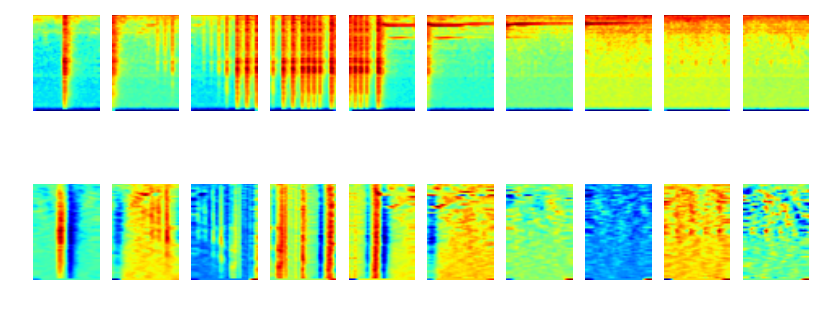

In [7]:
draw_10(x_train_wal)

Channel  0
Channel  1


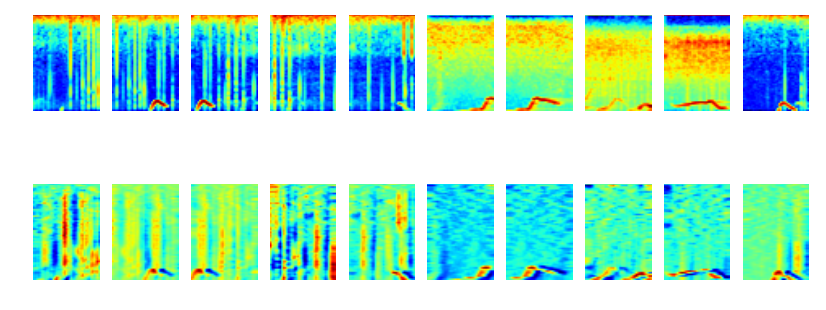

In [8]:
draw_10(x_train_dol)

Channel  0
Channel  1


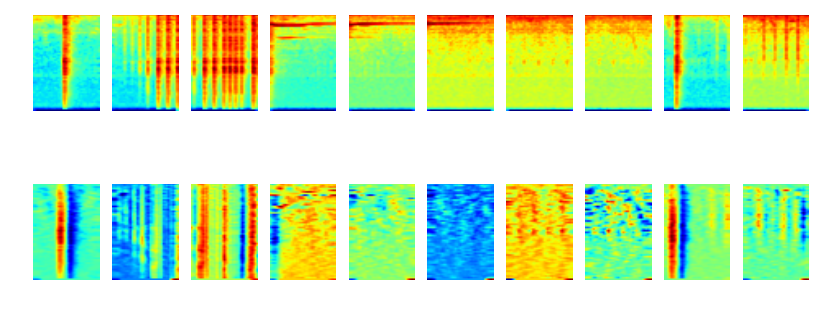

In [9]:
draw_10(x_val_wal)

Channel  0
Channel  1


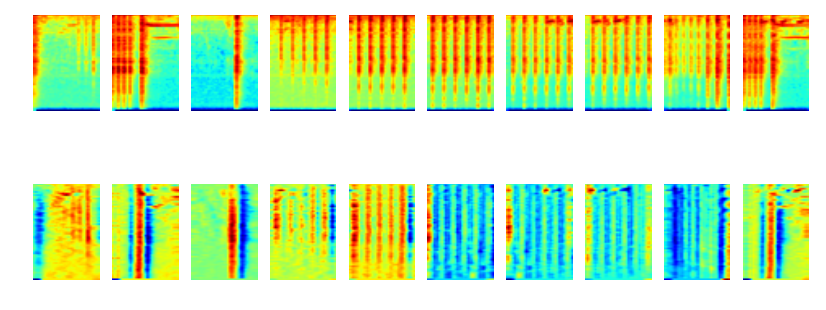

In [10]:
draw_10(x_val_dol)

In [11]:
STRIP_HEIGHT = xtrain.shape[1]
STRIP_WIDTH = xtrain.shape[2]
CHANNELS = xtrain.shape[3]
CLASSES = ytrain.shape[1]

In [12]:
class EvaluateValidation(Callback):      
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nValidation loss: {}, acc: {}\n'.format(loss, acc))

In [13]:
### Model ###                                                                                                                               
model = Sequential()                                                                                                                                                                      
k_init = 'he_normal'
bias_init = Constant(value=0.1)
ridge = 0.0002

model.add(Convolution2D(conv1_filter, kernel_size=(5, 3), strides=(1, 1),
                        padding='same', data_format="channels_last", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer=bias_init,
                        input_shape=(STRIP_HEIGHT, STRIP_WIDTH, CHANNELS)))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(conv2_filter, kernel_size=(10, 5), strides=(1, 1),
                        padding='same', data_format="channels_last", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer=bias_init))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (4, 2), strides=2, padding='valid'))

model.add(Convolution2D(conv3_filter, kernel_size=(14, 7), strides=(1, 1),
                        padding='same', data_format="channels_last", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer=bias_init))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(conv4_filter, kernel_size=(18, 9), strides=(1, 1),
                        padding='same', data_format="channels_last", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer=bias_init))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (4, 2), strides=2, padding='valid'))

model.add(Flatten())
model.add(Dense(512, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(256, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dense(256, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(CLASSES, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
# model.add(BatchNormalization())
model.add(Activation('softmax'))

Lr = 1e-4
dcy = 2e-5                                                                                                                                                                                
m = 0.5
batch_sz = 100
epoch = 150
sgd = SGD(lr=Lr, momentum=m, decay=dcy,  nesterov=True)
# adam = Adam(lr=Lr, decay=dcy)

model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()
print('learning rate: %f, decay: %f' %(Lr, dcy))

from keras.backend import get_session
get_session().run(tf.global_variables_initializer())
a = model.fit(xtrain, ytrain, batch_size = batch_sz, epochs= epoch, verbose = 2,
              validation_data=(xval, yval))

loss_and_metrics = model.evaluate(xtest, ytest)

print "Loss and accuracy: ", loss_and_metrics

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 41, 8)         248       
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 41, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 60, 41, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 41, 16)        6416      
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 41, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 60, 41, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 20, 16)        0         
__________

In [14]:
def one_hot(labels):
    n_values = len(np.unique(labels))
    return np.eye(n_values)[labels]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size='xx-large')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
i = 0
for layer in model.layers:
    print "{}: {}".format(i,layer)
    i += 1

0: <keras.layers.convolutional.Conv2D object at 0x2aab18951f50>
1: <keras.layers.normalization.BatchNormalization object at 0x2aab18951e90>
2: <keras.layers.core.Activation object at 0x2aab1895e490>
3: <keras.layers.convolutional.Conv2D object at 0x2aab1842ebd0>
4: <keras.layers.normalization.BatchNormalization object at 0x2aab1895e0d0>
5: <keras.layers.core.Activation object at 0x2aab18dfbe90>
6: <keras.layers.pooling.MaxPooling2D object at 0x2aab183cdc10>
7: <keras.layers.convolutional.Conv2D object at 0x2aab183b7450>
8: <keras.layers.normalization.BatchNormalization object at 0x2aab187613d0>
9: <keras.layers.core.Activation object at 0x2aab185a2ad0>
10: <keras.layers.convolutional.Conv2D object at 0x2aab18a30ed0>
11: <keras.layers.normalization.BatchNormalization object at 0x2aab18898850>
12: <keras.layers.core.Activation object at 0x2aab186877d0>
13: <keras.layers.pooling.MaxPooling2D object at 0x2aab1831fbd0>
14: <keras.layers.core.Flatten object at 0x2aab185a1250>
15: <keras.laye

In [16]:
y_test = ytest
y_pred = model.predict(xtest)
CLASS = ['Walrus','White-sided Dolphin']

Confusion matrix, without normalization
[[46  0]
 [ 0 25]]


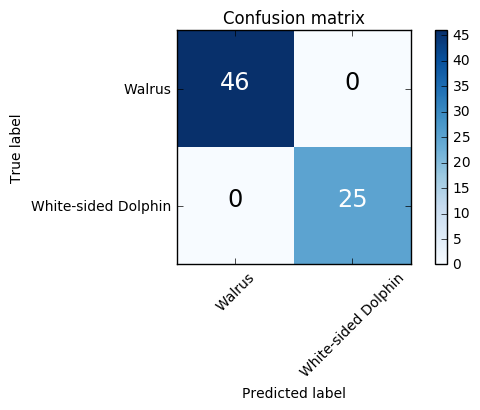

In [17]:
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)
conf_mat = metrics.confusion_matrix(y_test_class, y_pred_class)
plot_confusion_matrix(conf_mat, classes=CLASS)

In [19]:
# Compute ROC curve and ROC area for each class
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

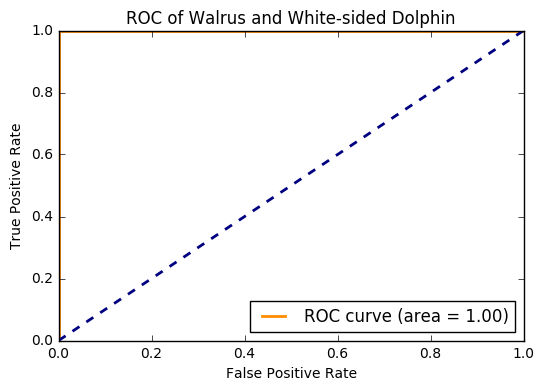

In [20]:
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of {} and {}'.format(CLASS[0], CLASS[1]))
plt.legend(loc="lower right")
plt.show()

In [21]:
def draw_weight(layer):
    filter_weights = np.array(model.layers[layer].get_weights())[0]
    arr_filters = np.zeros(filter_weights[:,:,0,0].shape)
    channels = filter_weights.shape[2]
    num_filters = filter_weights.shape[3]
    fig, axes = plt.subplots(1, 4, figsize=(10, 4))
    count = 0
    for i in range(2):
        for j in range(2):
            temp = filter_weights[:,:,j,i]
            print temp.shape
            arr_filters = np.concatenate((arr_filters, temp))
            axes[count].imshow(temp, interpolation='bilinear')
            count += 1
    return arr_filters

(18, 9)
(18, 9)
(18, 9)
(18, 9)


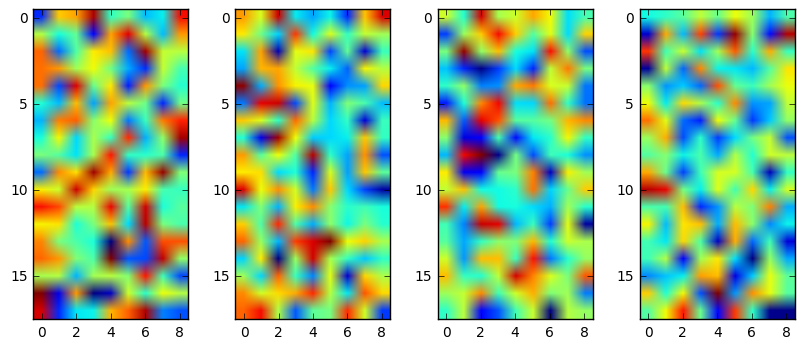

In [22]:
 layer10 = draw_weight(10)

(14, 7)
(14, 7)
(14, 7)
(14, 7)


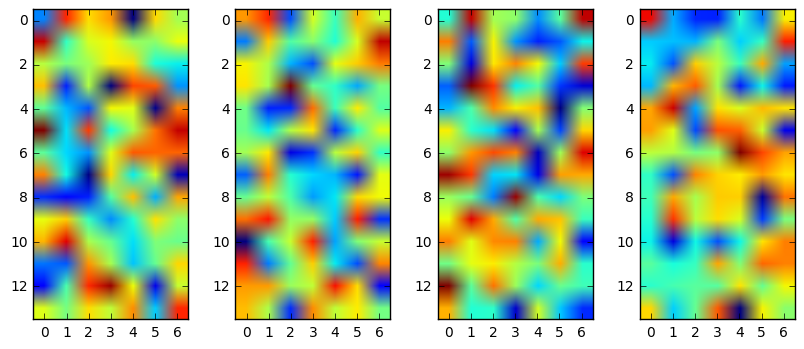

In [23]:
layer10 = draw_weight(7)

(10, 5)
(10, 5)
(10, 5)
(10, 5)


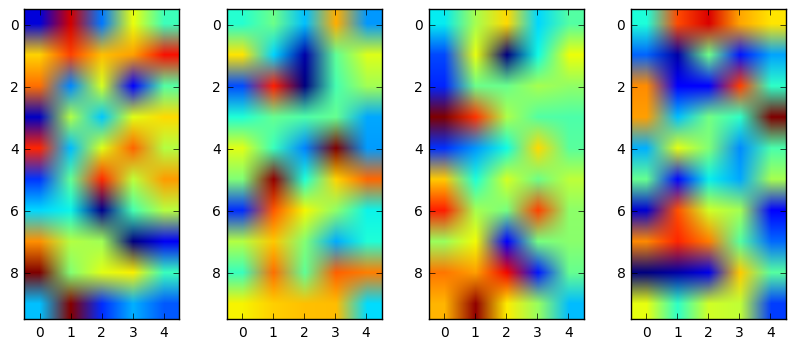

In [24]:
layer10 = draw_weight(3)

(5, 3)
(5, 3)
(5, 3)
(5, 3)


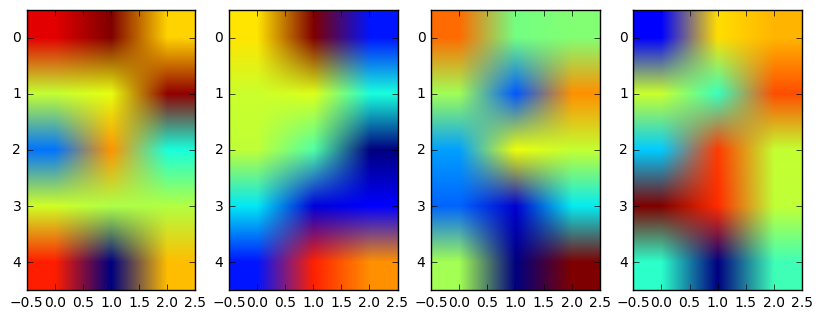

In [25]:
layer10 = draw_weight(0)